Requires notebook 5.

In [35]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(scITD)
  library(viridis)
  library(parallel)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
data <- prepare_gut_tx_and_meta()
cell_annot <- data[[1]]

ct_list_df <- DatasetPath('mouse_gut_rna', 'aviv_gut_markers_sub2.csv') %>% read.csv()
# ct_list_df <- read.csv(file='/home/jmitchel/data/spatial_data/gut_data/aviv_gut_markers_sub2.csv')

stemta.marker.genes <- ct_list_df[ct_list_df$cell_type=='Stem + TA','Gene']
ent.marker.genes <- ct_list_df[ct_list_df$cell_type=='Enterocyte','Gene']
gob.marker.genes <- ct_list_df[ct_list_df$cell_type=='Goblet','Gene']


# load counts version of org and clean data
base_dir <- CachePath('gut_scaled_dat6/')
# base_dir <- '/home/jmitchel/data/spatial_data/gut_res2/scaled_dat6/'
so_spatial_orig <- file.path(base_dir, 'so_spatial_orig.rds') %>% readRDS()
so_spatial_cln <- file.path(base_dir, 'so_spatial_cln_20_full.rds') %>% readRDS()

dat_orig <- so_spatial_orig[['RNA']]$counts
meta_orig <- so_spatial_orig@meta.data

dat_cln <- so_spatial_cln[['RNA']]$counts
meta_cln <- so_spatial_cln@meta.data

# subset data to same cells and genes
cells_both <- intersect(colnames(dat_orig),colnames(dat_cln))
dat_orig <- dat_orig[,cells_both]
dat_cln <- dat_cln[,cells_both]
meta_orig <- meta_orig[cells_both,]
meta_cln <- meta_cln[cells_both,]

ndx_change <- which(rownames(dat_orig)=='H2-Eb1')
rownames(dat_orig)[ndx_change] <- 'H2.Eb1'
ndx_change <- which(rownames(dat_cln)=='H2-Eb1')
rownames(dat_cln)[ndx_change] <- 'H2.Eb1'


# appending cell centroid coordinates
meta_orig <- cbind.data.frame(meta_orig,cell_annot[rownames(meta_orig),c('x','y')])
meta_cln <- cbind.data.frame(meta_cln,cell_annot[rownames(meta_cln),c('x','y')])

[1] 548

[1] 13.14599

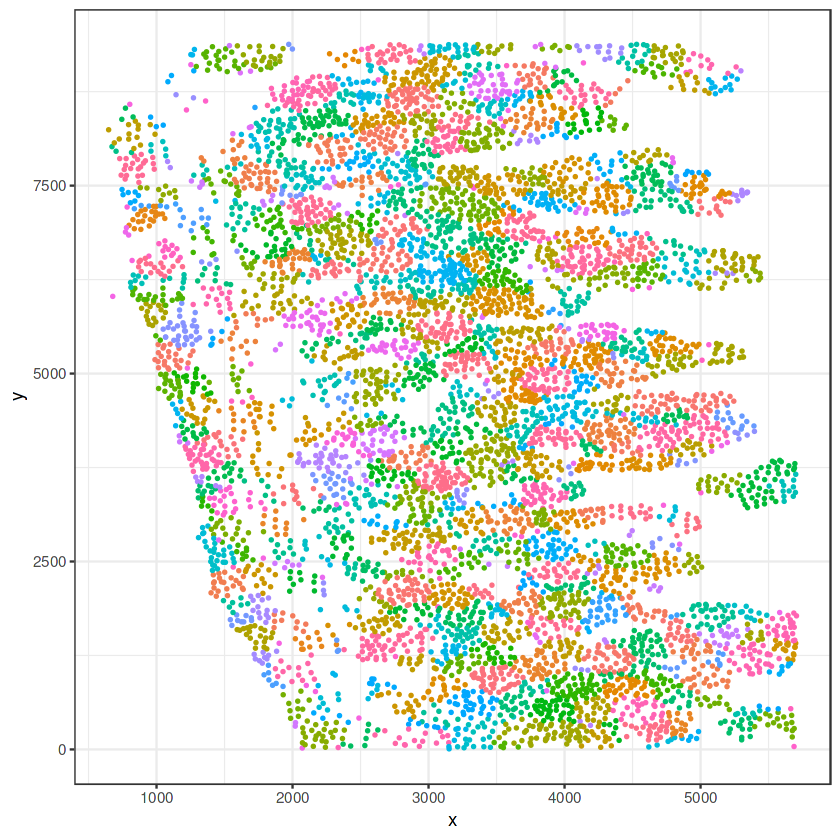

In [3]:
# compute spatial patches to use as niches as input to dialogue
diameter <- 400
get_cells_within_diameter <- function(meta_dup,centr_x,centr_y,diameter) {
  # compute euclidean distance from every cell to sampled cell
  distances <- sqrt((meta_dup$x - centr_x)**2 + (meta_dup$y - centr_y)**2)
  ndx_return <- which(distances<(diameter/2))
  return(ndx_return)
}

# add patch column
meta_dup <- meta_orig
meta_orig$patch <- NA
patch_iter <- 1
while(nrow(meta_dup)>0) {
  # randomly sample a cell
  cell_samp <- sample(1:nrow(meta_dup),1)
  centr_x <- meta_dup$x[cell_samp]
  centr_y <- meta_dup$y[cell_samp]
  cells_patch <- get_cells_within_diameter(meta_dup,centr_x,centr_y,diameter)
  cells_patch_names <- rownames(meta_dup)[cells_patch]

  # add patch info to meta_orig
  meta_orig[cells_patch_names,'patch'] <- patch_iter

  # remove patch cells from meta_dup
  ndx_dup <- 1:nrow(meta_dup)
  ndx_keep <- ndx_dup[!(ndx_dup %in% cells_patch)]
  meta_dup <- meta_dup[ndx_keep,]

  patch_iter <- patch_iter + 1
}

length(unique(meta_orig$patch))
mean(table(meta_orig$patch))

### plot the patches
# plot patches
meta_orig$patch_annot <- sapply(as.character(meta_orig$patch), function(x){
  paste0('patch_',x)
})

p <- ggplot(meta_orig,aes(x=x,y=y,color=as.factor(patch_annot))) + geom_point(size=.5) +
  theme(plot.title = element_text(hjust = 0.5),legend.position = "none")

p

meta_cln$patch <- meta_orig$patch
meta_cln$patch_annot <- meta_orig$patch_annot

# write_rds(meta_orig, CachePath('merfish_gut_annot_patches.rds'))

In [4]:
# The algorithm is sensitive to regenerating the patches, so we cached them
meta_orig <- read_rds(CachePath('merfish_gut_annot_patches.rds'))

Warning message in make_new_container(count_data = dat_orig, meta_data = meta_orig, :
“You may have included metadata that varies across cells within each donor/sample. 
              We recommend only including metadata that varies across donors/samples.”
parsing data matrix by cell/tissue type...

cleaning data...

Keeping 139 donors. All donors have at least 0 cells in each cell type included.

Consider using fewer cell types or reducing the donor_min_cells parameter to include more donors.

collapsing count matrices from cells to donors (aka pseudobulk operation)...

normalizing data...

calculating gene overdispersion factors...

selecting highly variable genes from each cell type...

scaling variance...

forming tensor...

Complete!



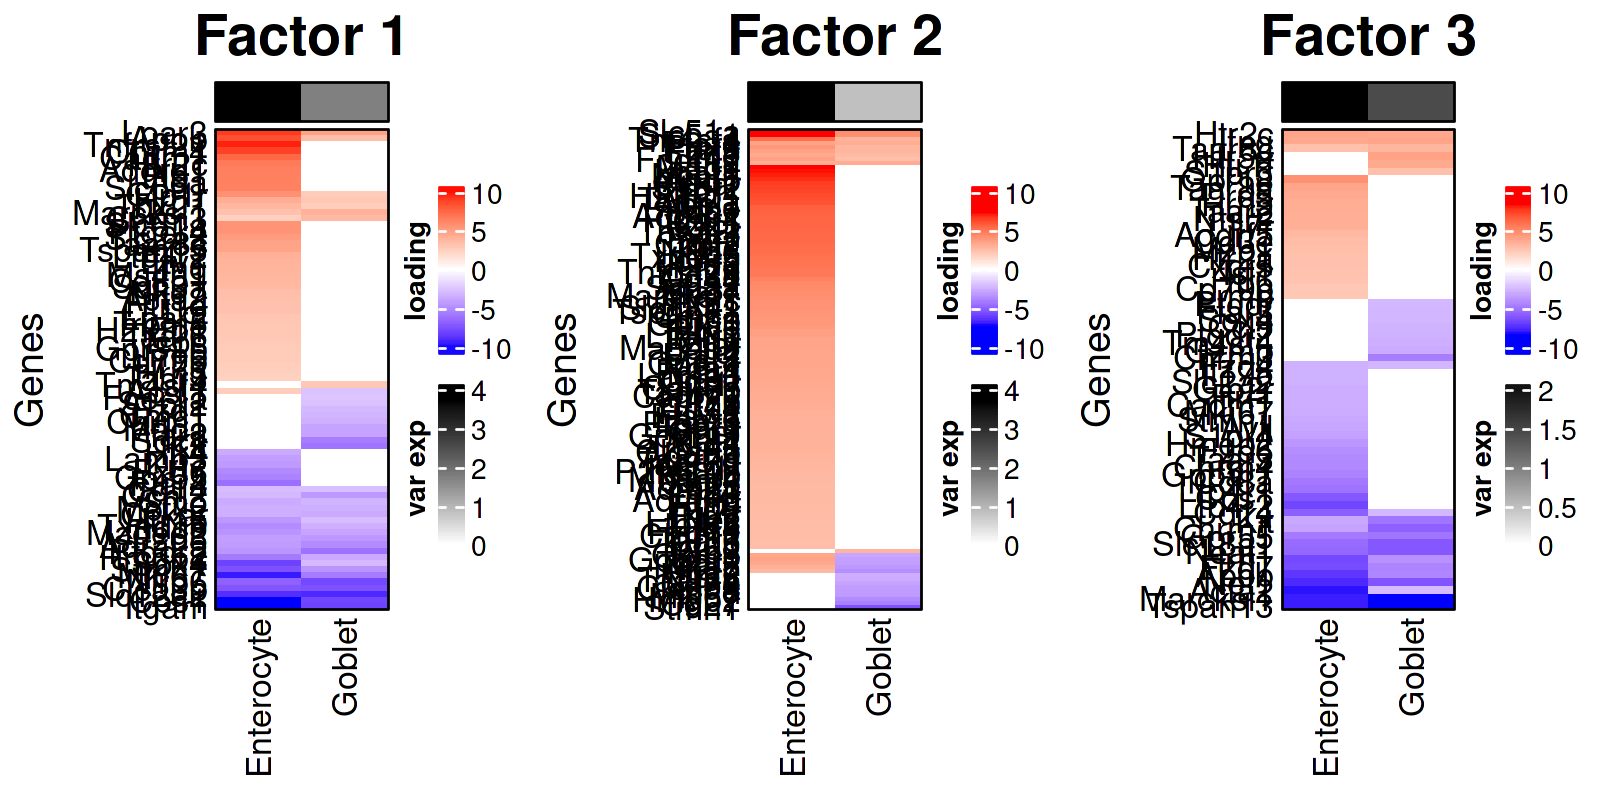

In [5]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)

# running scITD for original data

colnames(meta_orig)[which(colnames(meta_orig)=='cell_type')] <- 'ctypes'
colnames(meta_orig)[which(colnames(meta_orig)=='patch_annot')] <- 'donors'

param_list <- initialize_params(ctypes_use = c("Enterocyte","Goblet"),
                                ncores = 10, rand_seed = 10)

test_container_orig <- make_new_container(count_data=dat_orig,
                                          meta_data=meta_orig,
                                          params=param_list,
                                          label_donor_sex = FALSE)

test_container_orig <- form_tensor(test_container_orig, donor_min_cells=0,
                                   norm_method='trim', scale_factor=10000,
                                   vargenes_method='norm_var_pvals', vargenes_thresh=1,
                                   scale_var = TRUE, var_scale_power = .5)

test_container_orig <- run_tucker_ica(test_container_orig, ranks=c(3,14),
                                      tucker_type = 'regular', rotation_type = 'hybrid')

# get significant genes
test_container_orig <- get_lm_pvals(test_container_orig)

# generate the loadings plots
test_container_orig <- get_all_lds_factor_plots(test_container_orig,
                                                use_sig_only=TRUE,
                                                nonsig_to_zero=TRUE,
                                                sig_thresh=.05,
                                                display_genes=TRUE,
                                                gene_callouts = FALSE,
                                                show_var_explained = TRUE)

# arrange the plots into a figure and show the figure
myfig <- render_multi_plots(test_container_orig,data_type='loadings')
myfig

In [18]:
goblet_factor <- 2

parsing data matrix by cell/tissue type...

cleaning data...

Keeping 2538 donors. All donors have at least 0 cells in each cell type included.

Consider using fewer cell types or reducing the donor_min_cells parameter to include more donors.

collapsing count matrices from cells to donors (aka pseudobulk operation)...

normalizing data...



calculating gene overdispersion factors...

selecting highly variable genes from each cell type...

scaling variance...

forming tensor...

Complete!

parsing data matrix by cell/tissue type...

cleaning data...

Keeping 397 donors. All donors have at least 0 cells in each cell type included.

Consider using fewer cell types or reducing the donor_min_cells parameter to include more donors.

collapsing count matrices from cells to donors (aka pseudobulk operation)...

normalizing data...

calculating gene overdispersion factors...

selecting highly variable genes from each cell type...

scaling variance...

forming tensor...

Complete!



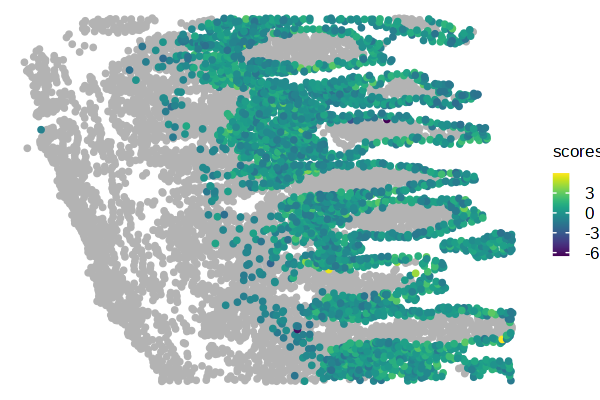

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

#### projecting factors onto individual cells so can better map them on the tissue
meta_orig_dup <- meta_orig
meta_orig_dup$donors <- NULL
meta_orig_dup$donors <- as.factor(rownames(meta_orig_dup))
meta_orig_dup$ctypes <- as.factor(meta_orig_dup$ctypes)

param_list2 <- initialize_params(ctypes_use = c("Enterocyte"),
                                 ncores = 10, rand_seed = 10)

test_container2 <- make_new_container(count_data=dat_orig,
                                      meta_data=meta_orig_dup,
                                      params=param_list2,
                                      label_donor_sex = FALSE)

test_container2 <- form_tensor(test_container2, donor_min_cells=0,
                               norm_method='trim', scale_factor=10000,
                               vargenes_method='norm_var_pvals', vargenes_thresh=1,
                               scale_var = TRUE, var_scale_power = .5)

test_container2 <- project_new_data(test_container2,test_container_orig)

param_list3 <- initialize_params(ctypes_use = c("Goblet"),
                                 ncores = 10, rand_seed = 10)

test_container3 <- make_new_container(count_data=dat_orig,
                                      meta_data=meta_orig_dup,
                                      params=param_list3,
                                      label_donor_sex = FALSE)

test_container3 <- form_tensor(test_container3, donor_min_cells=0,
                               norm_method='trim', scale_factor=10000,
                               vargenes_method='norm_var_pvals', vargenes_thresh=1,
                               scale_var = TRUE, var_scale_power = .5)

test_container3 <- project_new_data(test_container3,test_container_orig)

ent_scores <- test_container2$projected_scores[,goblet_factor]
gob_scores <- test_container3$projected_scores[,goblet_factor]
ent_scores_scale <- scale(ent_scores)
gob_scores_scale <- scale(gob_scores)
names(ent_scores_scale) <- names(ent_scores)
names(gob_scores_scale) <- names(gob_scores)
new_scores <- c(ent_scores_scale,gob_scores_scale)

meta_orig$all_scores <- NA
meta_orig[names(new_scores),'all_scores'] <- new_scores

cell_annot_no_color <- meta_orig[is.na(meta_orig$all_scores),]
cell_annot_color <- meta_orig[!is.na(meta_orig$all_scores),]

p <- ggplot(cell_annot_no_color,aes(x=x,y=y,color=all_scores)) +
  geom_point(size=gg_point_size/2) +
  geom_point(data=cell_annot_color,size=gg_point_size/2) +
  #   ggtitle('Goblets and Enterocytes scITD F1 scores') +
  scale_color_viridis(discrete = FALSE,na.value="grey70") +
  labs(color='scores') +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5,size=8),
        text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=6),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(6, 'pt'))

p

In [7]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(meta_orig$x) - min(meta_orig$x)
y_diff <- max(meta_orig$y) - min(meta_orig$y)
aspect_ratio <- y_diff / x_diff

width_plot <- 1.25
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 2.316355


In [8]:
pdf(OutputPath("gut_scITD_scores.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

In [9]:
pdf(OutputPath("gut_scITD_scores_legend.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p
dev.off()

png 
  2

In [20]:
# compute gene factor correlations for goblet cels
get_r_vals <- function(container, n.cores = container$experiment_params$ncores) {
  tensor_data <- container$tensor_data
  tucker_results <- container$tucker_results

  n_genes <- length(tensor_data[[2]])
  n_ctypes <- length(tensor_data[[3]])
  all_pvals <- data.frame(matrix(ncol=3,nrow=0))
  if (is.null(container$experiment_params$ncores)){
    n.cores = 1
  }
  all_corvals <- mclapply(1:n_genes, function(i) {
    gene <- tensor_data[[2]][i]
    gene_res <- list()
    for (j in 1:n_ctypes) {
      ctype <- tensor_data[[3]][j]
      gene_res[[ctype]] <- list()
      for (k in 1:ncol(tucker_results[[1]])) {
        tmp_fiber <- tensor_data[[4]][,i,j]

        # if expression is 0 for all donors just skip
        if (sum(tmp_fiber==0)==length(tmp_fiber)) {
          gene_res[[ctype]][[as.character(k)]]$value <- 0
        } else {
          df_test <- as.data.frame(cbind(tmp_fiber, tucker_results[[1]][,k]))
          colnames(df_test) <- c('fiber','factor')

          corval <- cor(df_test$fiber,df_test$factor)

          gene_res[[ctype]][[as.character(k)]] <- corval
        }
      }
    }
    return(gene_res)
  }, mc.cores = n.cores)

  names(all_corvals) <- tensor_data[[2]]

  # unpack the list
  all_corvals <- unlist(all_corvals)

  container[["gene_score_r"]] <- all_corvals
  return(container)
}

test_container_orig <- get_r_vals(test_container_orig)

genes <- sapply(names(test_container_orig$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[1]]
})
ct <- sapply(names(test_container_orig$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[2]]
})
factors <- sapply(names(test_container_orig$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[3]]
})

ndx_keep <- which(ct=='Goblet' & factors==goblet_factor)

gob_g_cors <- test_container_orig$gene_score_r[ndx_keep]
gob_genes <- genes[ndx_keep]
names(gob_g_cors) <- gob_genes

f_pvals <- get_one_factor_gene_pvals(test_container_orig, goblet_factor)

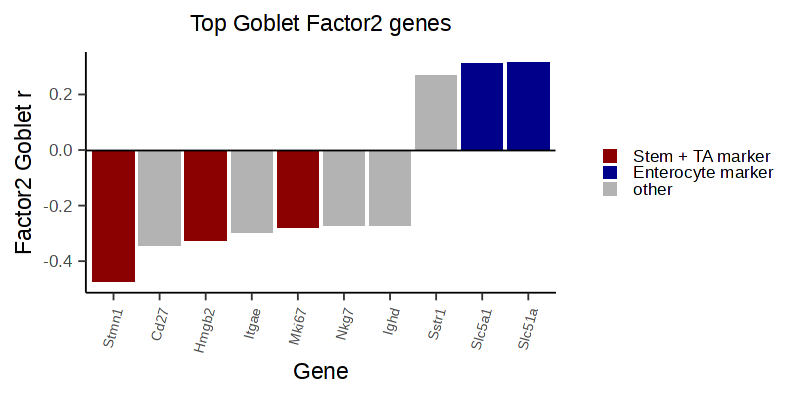

In [26]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 200)

### plotting gene-factor correlations with marker annotations
g_select <- f_pvals[,'Goblet']
g_select <- names(g_select)[g_select<.01]

# extract factor correlations for these genes
macro_lds <- gob_g_cors[g_select]
# select top n to have smaller list to show
n = 40
if (length(g_select)<n) {
  n <- length(g_select)
}
top_n_g <- names(macro_lds)[order(abs(macro_lds),decreasing=TRUE)[1:n]]
macro_lds <- macro_lds[top_n_g]
tmp <- as.data.frame(macro_lds)
g_ordered <- rownames(tmp)[order(tmp[,1],decreasing=FALSE)]
tmp$bar_order <- factor(rownames(tmp),levels=g_ordered)
tmp$marker <- sapply(rownames(tmp),function(x){
  if (x %in% stemta.marker.genes) {
    return('Stem + TA marker')
  } else if (x %in% ent.marker.genes) {
    return('Enterocyte marker')
  } else {
    return('other')
  }
})
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=bar_order,y=macro_lds,fill=marker)) +
  geom_col() +
  geom_hline(yintercept = 0,linewidth=gg_line_thickness) +
  ggtitle(paste0('Top Goblet Factor',goblet_factor,' genes')) +
  xlab('Gene') +
  ylab(paste0('Factor',goblet_factor,' Goblet r')) +
  scale_fill_manual(breaks = c('Stem + TA marker','Enterocyte marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title=element_blank(),
        axis.text.x = element_text(angle = 75, vjust = 1, hjust=1,size=5),
        legend.text=element_text(size=6),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(6, 'pt'))

p

In [27]:
pdf(OutputPath("gut_scITD_genes.pdf"), useDingbats = FALSE, width = 4, height = 2)
p
dev.off()

png 
  2

In [28]:
## run fgsea
mystats <- gob_g_cors
set_list <- list(stemta.marker.genes,ent.marker.genes)
names(set_list) <- c('stemta_markers','ent_markers')
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.83% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


          pathway        pval        padj         ES       NES nMoreExtreme
           <char>       <num>       <num>      <num>     <num>        <num>
1: stemta_markers 0.008298023 0.008298023 -0.7682508 -1.687560           46
2:    ent_markers 0.002395992 0.004791984  0.8900817  1.795579           10
    size  leadingEdge
   <int>       <list>
1:     9 Stmn1, H....
2:     6 Slc51a, ....


[1] 0.001332768

Warning message:
“Removed 267 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Notch went outside hinges
ℹ Do you want `notch = FALSE`?


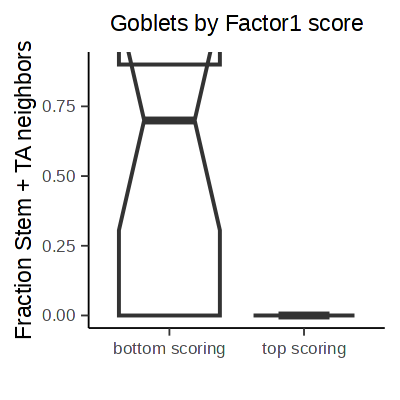

In [29]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 200)

## now computing average enterocytes adjacencies per goblet
knn_kval <- 10
meta_orig <- meta_orig[!is.na(meta_orig$x),]
all_knn = meta_orig %>% select(x, y) %>% FNN::get.knn(k = knn_kval) %>% .$nn.index
rownames(all_knn) <- rownames(meta_orig)

cells_keep <- rownames(meta_orig)[meta_orig$ctypes=='Goblet']
fracs_fib <- sapply(cells_keep,function(mycell) {
  nearest_cells <- all_knn[mycell,]
  return(sum(meta_orig[nearest_cells,'ctypes']=='Stem + TA')/knn_kval)
})

meta_orig$fracs_fib <- NA
meta_orig[names(fracs_fib),'fracs_fib'] <- fracs_fib

# trying to stratify by top/bottom 10th percent of macrophages by score
qs <- quantile(meta_orig$all_scores,probs = c(.05,.95),na.rm = TRUE)
top_ndx <- which(meta_orig$all_scores>qs[2])
cell_annot_top <- meta_orig[top_ndx,]
bot_ndx <- which(meta_orig$all_scores<qs[1])
cell_annot_bFactorot <- meta_orig[bot_ndx,]

cell_annot_top$sc_discrete <- 'top scoring'
cell_annot_bot$sc_discrete <- 'bottom scoring'

tmp <- rbind.data.frame(cell_annot_top,cell_annot_bot)

p <- ggplot(tmp,aes(x=sc_discrete,y=fracs_fib)) +
  geom_boxplot(notch = TRUE) +
  ylab('Fraction Stem + TA neighbors') +
  xlab('') +
  ggtitle(paste0('Goblets by Factor',goblet_factor,' score')) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5))

tres <- t.test(cell_annot_top$fracs_fib,cell_annot_bot$fracs_fib)
tres[["p.value"]]

p


In [30]:
pdf(OutputPath("gut_scITD_frac_fibs.pdf"), useDingbats=FALSE, width=2, height=2)
p
dev.off()

Warning message:
“Removed 267 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Notch went outside hinges
ℹ Do you want `notch = FALSE`?


png 
  2

Warning message in make_new_container(count_data = dat_cln, meta_data = meta_orig, :
“You may have included metadata that varies across cells within each donor/sample. 
              We recommend only including metadata that varies across donors/samples.”
parsing data matrix by cell/tissue type...

cleaning data...

Keeping 139 donors. All donors have at least 0 cells in each cell type included.

Consider using fewer cell types or reducing the donor_min_cells parameter to include more donors.

collapsing count matrices from cells to donors (aka pseudobulk operation)...

normalizing data...

calculating gene overdispersion factors...

selecting highly variable genes from each cell type...

scaling variance...

forming tensor...

Complete!



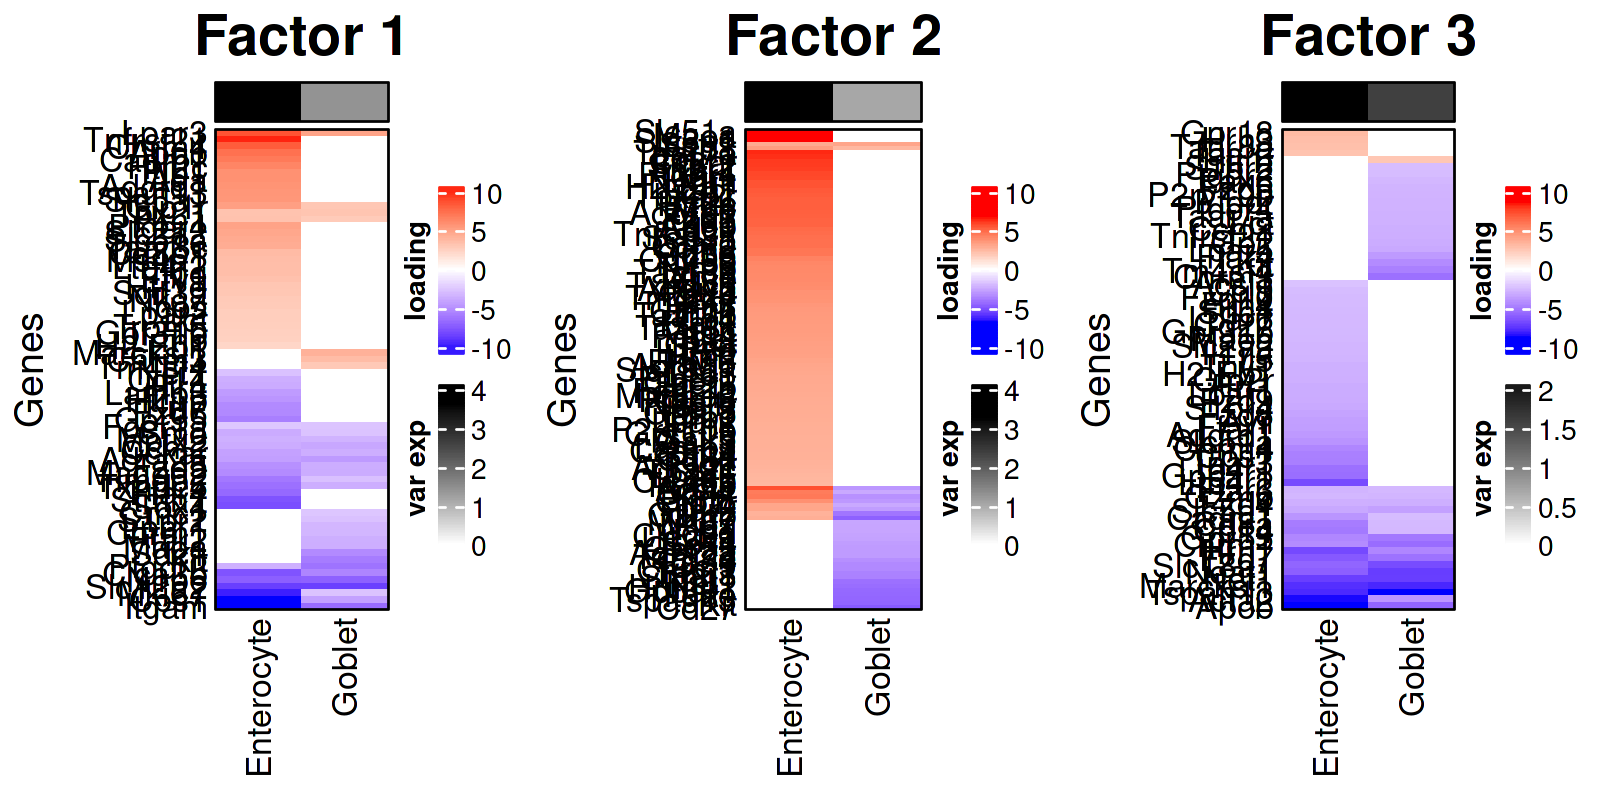

In [31]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)

# running scITD for cleaned data
param_list <- initialize_params(ctypes_use = c("Enterocyte","Goblet"),
                                ncores = 10, rand_seed = 10)

test_container_cln <- make_new_container(count_data=dat_cln,
                                         meta_data=meta_orig,
                                         params=param_list,
                                         label_donor_sex = FALSE)

test_container_cln <- form_tensor(test_container_cln, donor_min_cells=0,
                                  norm_method='trim', scale_factor=10000,
                                  vargenes_method='norm_var_pvals', vargenes_thresh=1,
                                  scale_var = TRUE, var_scale_power = .5)


test_container_cln <- run_tucker_ica(test_container_cln, ranks=c(3,14),
                                     tucker_type = 'regular', rotation_type = 'hybrid')

# test_container_cln <- run_tucker_ica(test_container_cln, ranks=c(3,6),
#                                  tucker_type = 'regular', rotation_type = 'hybrid')

# # flip sign of scores to match other example
# test_container_cln$tucker_results[[1]] <- test_container_cln$tucker_results[[1]] * -1
# test_container_cln$tucker_results[[2]] <- test_container_cln$tucker_results[[2]] * -1
# test_container_cln$projection_data[[1]] <- test_container_cln$projection_data[[1]] * -1

# get significant genes
test_container_cln <- get_lm_pvals(test_container_cln)

# generate the loadings plots
test_container_cln <- get_all_lds_factor_plots(test_container_cln,
                                               use_sig_only=TRUE,
                                               nonsig_to_zero=TRUE,
                                               sig_thresh=.05,
                                               display_genes=TRUE,
                                               gene_callouts = FALSE,
                                               show_var_explained = TRUE)

# arrange the plots into a figure and show the figure
myfig <- render_multi_plots(test_container_cln,data_type='loadings')
myfig

In [32]:
# Identifying which new factor corresponds to the original factor 2
sc1 <- test_container_orig$tucker_results[[1]]
sc2 <- test_container_cln$tucker_results[[1]]
samp_both <- intersect(rownames(sc1),rownames(sc2))
sc1 <- sc1[samp_both,]
sc2 <- sc2[samp_both,]
cormat <- cor(sc1,sc2)
cormat

0.98548525,0.09801355,-0.04744433
-0.09107085,0.91915251,-0.30598123
0.02729662,0.27131626,0.90139108


In [37]:
goblet_factor <- 2

In [38]:
# compute gene factor correlations for goblet cels
test_container_cln <- get_r_vals(test_container_cln)

genes <- sapply(names(test_container_cln$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[1]]
})
ct <- sapply(names(test_container_cln$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[2]]
})
factors <- sapply(names(test_container_cln$gene_score_r),function(x){
  strsplit(x,split='.',fixed = TRUE)[[1]][[3]]
})

ndx_keep <- which(ct=='Goblet' & factors==2)

gob_g_cors_cln <- test_container_cln$gene_score_r[ndx_keep]
gob_genes <- genes[ndx_keep]
names(gob_g_cors_cln) <- gob_genes

f_pvals_cln <- get_one_factor_gene_pvals(test_container_cln,goblet_factor)

Warning message:
“Removed 231 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


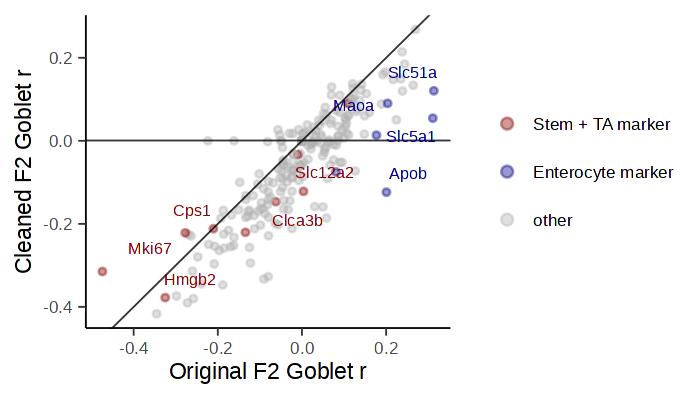

In [39]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

# plot loadings for cleaned vs original
g_both <- intersect(names(gob_g_cors),names(gob_g_cors_cln))
tmp <- cbind.data.frame(gob_g_cors[g_both],gob_g_cors_cln[g_both])
colnames(tmp) <- c('orig','clean')
g_to_label <- c('Maoa','Slc5a1','Apob','Slc51a','Cps1','Clca3b','Slc12a2','Mki67','Hmgb2')
tmp$glab <- NA
ndx_lab <- which(rownames(tmp) %in% g_to_label)
tmp[ndx_lab,'glab'] <- rownames(tmp)[ndx_lab]


tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% stemta.marker.genes) {
    return('Stem + TA marker')
  } else if (x %in% ent.marker.genes) {
    return('Enterocyte marker')
  } else {
    return('other')
  }
})

ymax <- max(abs(tmp$clean))
tmp$markers <- factor(tmp$markers,levels=c('Stem + TA marker','Enterocyte marker','other'))
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_abline(linewidth=gg_line_thickness,slope = 1,intercept=0,alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness,yintercept = 0,alpha=gg_line_alpha) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  xlab(paste0('Original F',goblet_factor,' Goblet r')) +
  ylab(paste0('Cleaned F',goblet_factor,' Goblet r')) +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_colour_manual(breaks = c('Stem + TA marker','Enterocyte marker','other'), values = myColors) +
  p_theme +
  theme(legend.title=element_blank()) +
  legend_mod

p

In [40]:
pdf(OutputPath("gut_scITD_r_cor.pdf"), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 231 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2